In [1]:
!pip install kaggle

In [2]:
from typing import Iterable, Callable, Dict, Tuple
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike
import data_utils as du

In [3]:
!~/.local/bin/kaggle datasets download -d rohitrox/healthcare-provider-fraud-detection-analysis -p data

healthcare-provider-fraud-detection-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!cd data && unzip -n '*.zip'

Archive:  healthcare-provider-fraud-detection-analysis.zip


In [5]:
DATA_DIR = 'data/'

In [6]:
provider_df = du.make_provider_df(DATA_DIR)
provider_df

,provider,potentialFraud,potentialFraudInd
0,PRV51001,No,0
1,PRV51003,Yes,1
2,PRV51004,No,0
3,PRV51005,Yes,1
4,PRV51007,No,0
...,...,...,...
5405,PRV57759,No,0
5406,PRV57760,No,0
5407,PRV57761,No,0
5408,PRV57762,No,0


In [7]:
claim_df = du.make_claim_df(DATA_DIR)
claim_df

,beneID,claimID,claimStartDt,claimEndDt,provider,inscClaimAmtReimbursed,attendingPhysician,operatingPhysician,otherPhysician,admissionDt,...,chronicCondIschemicHeartInd,chronicCondOsteoporasisInd,chronicCondrheumatoidarthritisInd,chronicCondstrokeInd,dobYear,isDeceased,maxDate,approxAge,renalDiseaseIndicatorNum,renalDiseaseFlag
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,0,1,1,1943,0,2009-12-01,67.0,0,0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,0,1,1,1943,0,2009-12-01,67.0,0,0
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,0,1,1,1943,0,2009-12-01,67.0,0,0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,0,0,1,1,1914,0,2009-12-01,95.8,0,0
4,BENE11011,CLM144521,2009-01-18,2009-01-18,PRV52314,50,PHY379398,NaN,NaN,NaT,...,0,0,1,1,1914,0,2009-12-01,95.8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaT,...,0,0,1,0,1952,0,2009-12-01,57.7,0,0
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaT,...,0,0,1,0,1952,0,2009-12-01,57.7,0,0
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaT,...,0,0,1,0,1952,0,2009-12-01,57.7,0,0
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaT,...,0,0,1,0,1952,0,2009-12-01,57.7,0,0


## Example Class imbalance
As a first step let us examine class imbalance.  In most fraud problems we expect a highly imbalanced dataset with an extremly small number of fraud observations relative to others

In [8]:
provider_df.potentialFraudInd.mean()
print(f'About {provider_df.potentialFraudInd.mean():.2%} of providers are marked as potential fraud.')

About 9.35% of providers are marked as potential fraud.


In [9]:
#create a combined dataset to make EDA easier
df = claim_df.merge(provider_df, on='provider')

print(f'About {df.potentialFraudInd.mean():.2%} of claims are made by potential fraud providers.')

About 38.12% of claims are made by potential fraud providers.


The above numbers seem high. It is hard to concieve that 38.12% of provider claims in the United States are fraudulant.  This suggests that either
1. This dataset reflects a narrowed down subset of providers and/or claims. Ones that were previously flagged as suspicious. 
2. The labeling is intended for a flagging system further upstream to be followed by other methods for narrowing down on truely fraudulent providers. 

Either way it should be okay for our intents and purposes.  We can create an ML model for this stage in a fraud detection system either way.  

Ultimatly, There is some class imbalance here, but it isn't extreme.  This means that we may need to rebalance or reweight for model training, but it may not be completly necessary and we will probably not be faced with extreme challenges here as is often the case with other fraudf detection problems. 


One thing to note is that the above numbers suggest fraudulant providers create more claims, on average, than non-fraudulent ones. 

### Theories (based off of features easy to aggregate in a table)
There are a lot of different ways we could go here.  Here are some recommendations based off other analysis on Kaggle. 

Where is medical provider fraud more liklely to happen?
1. inpatient vs outpatient? - inpatient could be more expensive so fraud may occur more with inpatient claims
2. by area: state/couynty? - some areas may have high fraud rates then others
3. Is provider fraud concentrated in certain patient demographics: race, age, gender?
4. Types of patients based on chronic conditions - fraud may be more common in certain medical practices or for treatment of certain conditions
5. Use of certain diagnosis or group codes? - I think the group codes dictate what the providers can charge for services, and I think the diagnosis codes are also part of the process.  Certain codes may be used more in fraud instances due to the amount of money they allow providers to charge. 

Things that may be indicators of medical provider fraud....
1. High number of claims
2. High claim reimbursments amounts
3. Lack of physician presence on the claim
4. Inconsistent patient demographics (i.e. high varience in age)
5. Inconsitent patient conditions (i.e. high variance in chromic conditions and desease)

__inpatient vs outpatient? - inpatient could be more expensive so fraud may occur more with inpatient claims__

Text(0.5, 0.98, 'Inpatient Fraction by Fraud Indicator')

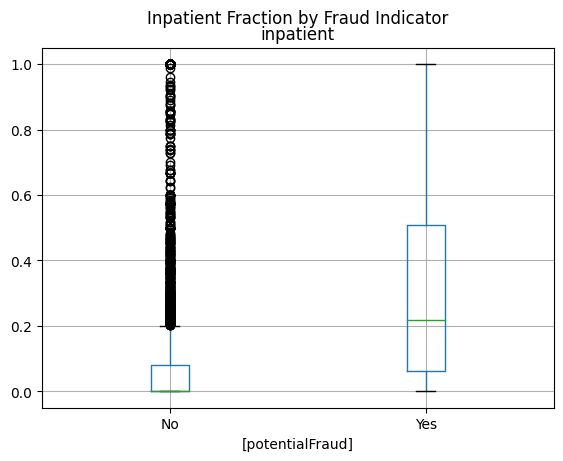

In [10]:
agg_df = df[['provider','potentialFraud','inpatient']].groupby(['provider', 'potentialFraud']).agg({'inpatient':'mean'}).reset_index('potentialFraud')
ax = agg_df.boxplot(by='potentialFraud')
ax.get_figure().suptitle('Inpatient Fraction by Fraud Indicator')

You can see a pattern here.  This variable should be included for AutoML

In [11]:
# Lets create a dictionary to hold the features we wangt to use....we will merge them into a final dataframe at the end. 
feature_dfs = {}

feature_dfs['inpationFraction'] = agg_df.reset_index().rename(columns = {'inpatient': 'inpationFraction'}).drop(columns = 'potentialFraud')
feature_dfs

{'inpationFraction':       provider  inpationFraction
 0     PRV51001          0.200000
 1     PRV51003          0.469697
 2     PRV51004          0.000000
 3     PRV51005          0.000000
 4     PRV51007          0.041667
 ...        ...               ...
 5405  PRV57759          0.000000
 5406  PRV57760          0.000000
 5407  PRV57761          0.000000
 5408  PRV57762          0.000000
 5409  PRV57763          0.000000
 
 [5410 rows x 2 columns]}

__by area: state/county? - some areas may have high fraud rates then others__

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)

Text(0.5, 0.98, 'Fraud Provider Fraction by State')

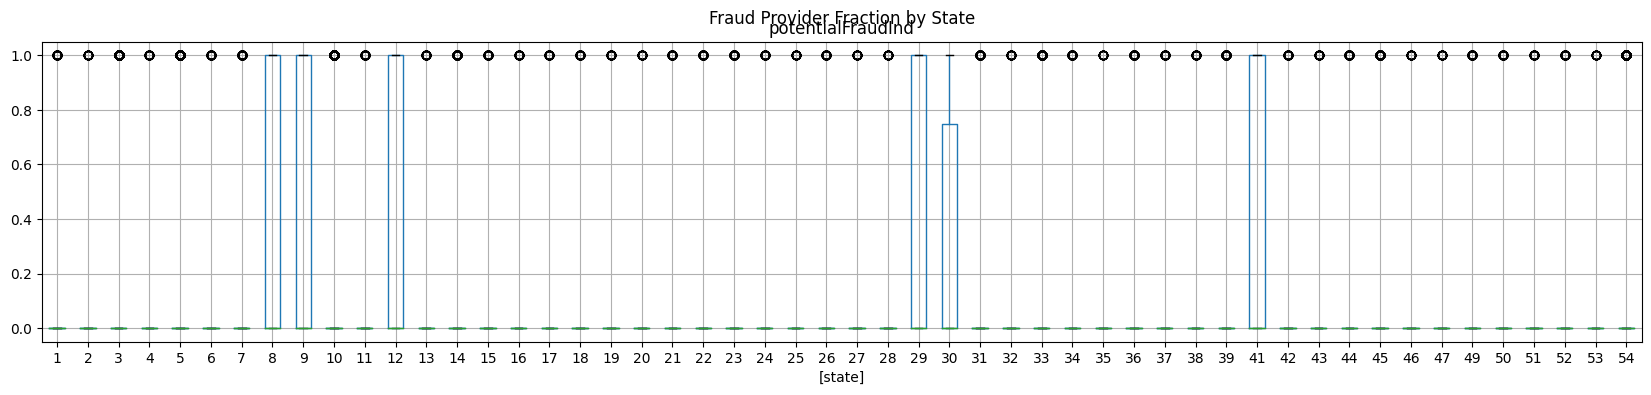

In [13]:
agg_df = df[['provider', 'potentialFraudInd','state']].groupby(['provider', 'state']).agg({'potentialFraudInd':'mean'}).reset_index('state')
ax = agg_df.boxplot(by='state')
ax.get_figure().suptitle('Fraud Provider Fraction by State')

In [14]:
#ensures unique county per us state
#df['stateCounty'] = df.state + df.county

What we see above is mostly the same distribution across the majority of states - mostly zero with a minority of fraud providers.  The few states we see a bar for are relatively uniform in distribution. It is possible there is some signal here, it doesn't appear too dramtic though. Because we cannot control the way AuotML will use the feature, lets exclude for now, barring further analysis, to avoid unintened regional biases. County is an even smaller sub-level, so we will exclude that for now too. 

__Is provider fraud concentrated in certain patient demographics: race, age, gender?__

Text(0.5, 0.98, 'Fraud Provider Fraction by Race')

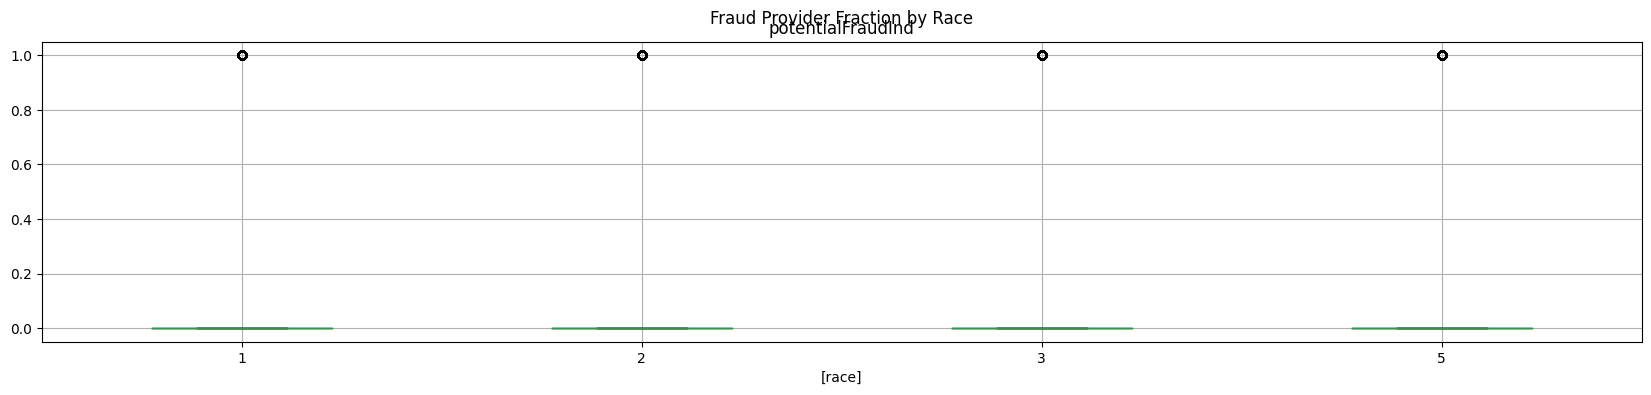

In [15]:
agg_df = df[['provider', 'potentialFraudInd','race']].groupby(['provider', 'race']).agg({'potentialFraudInd':'mean'}).reset_index('race')
ax = agg_df.boxplot(by='race')
ax.get_figure().suptitle('Fraud Provider Fraction by Race')

In [16]:
df.race.nunique()

4

Types of patients based on chronic conditions - fraud may be more common in certain medical practices or for treatment of certain conditions

In [18]:
## The chronic condition columns are codes as 1=True 2+False.  Lets make 0=False for consitency
for col in df.columns:
    if 'chronicCond' in col: 
        df.loc[df[col] == 2, col] = 0
df[[col for col in df.columns if 'chronicCond' in col]]

,chronicCondAlzheimer,chronicCondHeartfailure,chronicCondKidneyDisease,chronicCondCancer,chronicCondObstrPulmonary,chronicCondDepression,chronicCondDiabetes,chronicCondIschemicHeart,chronicCondOsteoporasis,chronicCondrheumatoidarthritis,...,chronicCondHeartfailureInd,chronicCondKidneyDiseaseInd,chronicCondCancerInd,chronicCondObstrPulmonaryInd,chronicCondDepressionInd,chronicCondDiabetesInd,chronicCondIschemicHeartInd,chronicCondOsteoporasisInd,chronicCondrheumatoidarthritisInd,chronicCondstrokeInd
0,1,0,1,0,0,1,1,1,0,1,...,0,1,0,0,1,1,1,0,1,1
1,1,1,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
2,1,1,1,0,1,0,0,1,0,0,...,1,1,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0,1,0,0,1,0,1,1,1,1,...,1,0,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,0,0
558207,1,0,1,0,0,0,1,1,0,1,...,0,1,0,0,0,1,1,0,1,0
558208,1,1,1,0,1,0,1,1,0,0,...,1,1,0,1,0,1,1,0,0,0
558209,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [19]:
# Now combine into condition encoding vector
condition_cols = ['renalDiseaseIndicatorNum'] + [col for col in df.columns if 'chronicCond' in col]
df['conditions'] = df[condition_cols].values.tolist()
df.conditions = df.conditions.apply(np.array)
df[['conditions'] + condition_cols]

,conditions,renalDiseaseIndicatorNum,chronicCondAlzheimer,chronicCondHeartfailure,chronicCondKidneyDisease,chronicCondCancer,chronicCondObstrPulmonary,chronicCondDepression,chronicCondDiabetes,chronicCondIschemicHeart,...,chronicCondHeartfailureInd,chronicCondKidneyDiseaseInd,chronicCondCancerInd,chronicCondObstrPulmonaryInd,chronicCondDepressionInd,chronicCondDiabetesInd,chronicCondIschemicHeartInd,chronicCondOsteoporasisInd,chronicCondrheumatoidarthritisInd,chronicCondstrokeInd
0,"[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ...",0,1,0,1,0,0,1,1,1,...,0,1,0,0,1,1,1,0,1,1
1,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",0,1,1,1,0,0,0,0,1,...,1,1,0,0,0,0,1,0,0,0
2,"[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",0,1,1,1,0,1,0,0,1,...,1,1,0,1,0,0,1,0,0,0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
4,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, ...",0,0,1,0,0,1,0,1,1,...,1,0,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
558207,"[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, ...",0,1,0,1,0,0,0,1,1,...,0,1,0,0,0,1,1,0,1,0
558208,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...",1,1,1,1,0,1,0,1,1,...,1,1,0,1,0,1,1,0,0,0
558209,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...",0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [20]:
## aggregate to provider level
def normalize_sum(x):
    res = sum(x)
    d = sum(res)
    if d > 0:
        res = res/d
    return res
        
    return res/res.sum()

agg_df = (df[['provider', 'potentialFraudInd', 'conditions']].groupby(['provider', 'potentialFraudInd'])
               .agg({'conditions':normalize_sum}).reset_index())

In [21]:
from sklearn.manifold import TSNE
# instantiate the TSNE model
tsne = TSNE(n_components=2, random_state=7474, init='random', learning_rate="auto")
# Use the TSNE model to fit and output a 2-d representation
E = tsne.fit_transform(np.stack(agg_df['conditions'], axis=0))

In [22]:
coord_df = pd.concat([agg_df, pd.DataFrame(E, columns=['x', 'y'])], axis=1)
coord_df['color'] = '#0000FF'
coord_df['marker'] = 'o'
coord_df.loc[coord_df.potentialFraudInd==1, 'color'] = '#FF0000'
coord_df.loc[coord_df.potentialFraudInd==1, 'marker'] = 'v'
coord_df

,provider,potentialFraudInd,conditions,x,y,color,marker
0,PRV51001,0,"[0.027972027972027972, 0.05244755244755245, 0....",-9.542064,-54.291523,#0000FF,o
1,PRV51003,1,"[0.023596419853539462, 0.045565500406834825, 0...",33.454914,-7.408651,#FF0000,v
2,PRV51004,0,"[0.017463933181473046, 0.04859529233105543, 0....",-33.160328,20.135929,#0000FF,o
3,PRV51005,1,"[0.02499758710549175, 0.04111572242061577, 0.0...",-14.144523,2.214782,#FF0000,v
4,PRV51007,0,"[0.01800327332242226, 0.0425531914893617, 0.06...",-35.862003,-0.155739,#0000FF,o
...,...,...,...,...,...,...,...
5405,PRV57759,0,"[0.016722408026755852, 0.046822742474916385, 0...",9.879543,-9.095353,#0000FF,o
5406,PRV57760,0,"[0.0, 0.01948051948051948, 0.07142857142857142...",33.140602,45.435425,#0000FF,o
5407,PRV57761,0,"[0.028151774785801713, 0.044063647490820076, 0...",-22.955120,-28.867601,#0000FF,o
5408,PRV57762,0,"[0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0, 0.1, 0.1, ...",53.111633,-5.534049,#0000FF,o


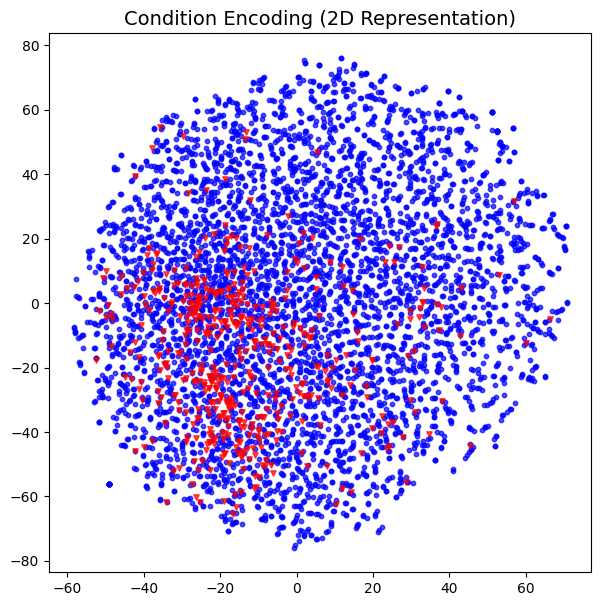

In [23]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.title('Condition Encoding (2D Representation)', fontsize=14)
plt.scatter(coord_df[coord_df.potentialFraudInd==0].x, 
            coord_df[coord_df.potentialFraudInd==0].y, 
            s=10, 
            marker='o', 
            c='#0000FF', 
            alpha=0.7)

plt.scatter(coord_df[coord_df.potentialFraudInd==1].x, 
            coord_df[coord_df.potentialFraudInd==1].y, 
            s=15, 
            marker='v', 
            c='#FF0000', 
            alpha=0.7)

While it may not be strong, there does seem to be a pattern here. YOu can see the tighter red clustering.  Lets include the condtion encoding as a feature. 

In [24]:
# break out condition enc into  seperate columns
agg_df[[col + 'Enc' for col in condition_cols]] = agg_df.conditions.tolist()

In [25]:
feature_dfs['conditionEnc'] = agg_df.drop(columns = ['conditions', 'potentialFraudInd'])
feature_dfs['conditionEnc']

,provider,renalDiseaseIndicatorNumEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,chronicCondDiabetesEnc,chronicCondIschemicHeartEnc,...,chronicCondHeartfailureIndEnc,chronicCondKidneyDiseaseIndEnc,chronicCondCancerIndEnc,chronicCondObstrPulmonaryIndEnc,chronicCondDepressionIndEnc,chronicCondDiabetesIndEnc,chronicCondIschemicHeartIndEnc,chronicCondOsteoporasisIndEnc,chronicCondrheumatoidarthritisIndEnc,chronicCondstrokeIndEnc
0,PRV51001,0.027972,0.052448,0.066434,0.059441,0.017483,0.034965,0.031469,0.073427,0.080420,...,0.066434,0.059441,0.017483,0.034965,0.031469,0.073427,0.080420,0.020979,0.027972,0.020979
1,PRV51003,0.023596,0.045566,0.065094,0.052075,0.008137,0.033360,0.043938,0.081367,0.091131,...,0.065094,0.052075,0.008137,0.033360,0.043938,0.081367,0.091131,0.026851,0.030919,0.009764
2,PRV51004,0.017464,0.048595,0.066819,0.037965,0.012149,0.031131,0.047836,0.079727,0.082005,...,0.066819,0.037965,0.012149,0.031131,0.047836,0.079727,0.082005,0.037206,0.034928,0.012908
3,PRV51005,0.024998,0.041116,0.065631,0.048934,0.015925,0.028472,0.046810,0.077116,0.086382,...,0.065631,0.048934,0.015925,0.028472,0.046810,0.077116,0.086382,0.033201,0.031947,0.011968
4,PRV51007,0.018003,0.042553,0.065466,0.036007,0.019640,0.026187,0.047463,0.080196,0.083470,...,0.065466,0.036007,0.019640,0.026187,0.047463,0.080196,0.083470,0.034370,0.036007,0.019640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.016722,0.046823,0.066890,0.050167,0.013378,0.036789,0.030100,0.066890,0.093645,...,0.066890,0.050167,0.013378,0.036789,0.030100,0.066890,0.093645,0.043478,0.030100,0.013378
5406,PRV57760,0.000000,0.019481,0.071429,0.012987,0.000000,0.012987,0.045455,0.116883,0.142857,...,0.071429,0.012987,0.000000,0.012987,0.045455,0.116883,0.142857,0.071429,0.006494,0.000000
5407,PRV57761,0.028152,0.044064,0.068543,0.048960,0.017136,0.036720,0.046512,0.067319,0.075887,...,0.068543,0.048960,0.017136,0.036720,0.046512,0.067319,0.075887,0.039168,0.029376,0.012240
5408,PRV57762,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,...,0.000000,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000


__Use of certain diagnosis or group codes?__ 
I think the group codes dictate what the providers can charge for services, and I think the diagnosis codes are also part of the process.  Certain codes may be used more in fraud instances due to the amount of money they allow providers to charge

Lets start with Diagnosis group codes. To invistigate this, we need some way to represent the different types of group codes used in by fraud and non-fraud providers

<AxesSubplot:xlabel='count', ylabel='mean'>

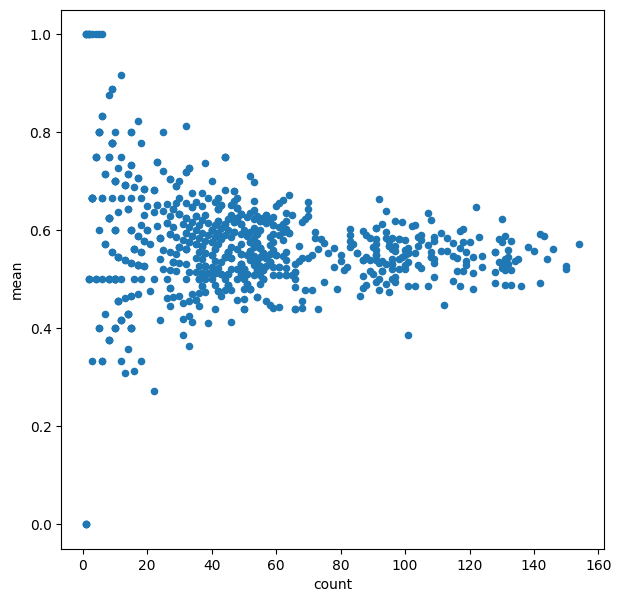

In [26]:
agg_df = df[['provider', 'diagnosisGroupCode', 'potentialFraudInd']] \
    .dropna().drop_duplicates()\
    .groupby('diagnosisGroupCode').agg({'potentialFraudInd':['mean', 'count', 'sum']})

agg_df.columns = [col[1] for col in agg_df.columns]

agg_df = agg_df.reset_index()

agg_df

agg_df.plot.scatter(x='count', y='mean')

In [27]:
# create a reshaped diasgnosis code dataframe
code_cols = [col for col in df.columns if 'clmDiagnosisCode' in col]
code_df = pd.wide_to_long(df[code_cols  + ['claimID', 'provider', 'potentialFraudInd']], stubnames='clmDiagnosisCode', i='claimID', j='codeNumber').dropna().reset_index()
code_df

,claimID,codeNumber,potentialFraudInd,provider,clmDiagnosisCode
0,CLM46614,1,1,PRV55912,1970
1,CLM565430,1,1,PRV55912,V7183
2,CLM34721,1,1,PRV55912,4240
3,CLM72336,1,1,PRV55912,V5789
4,CLM73394,1,1,PRV55912,71535
...,...,...,...,...,...
1680711,CLM547191,10,0,PRV55417,E9689
1680712,CLM743911,10,0,PRV53644,2720
1680713,CLM522928,10,0,PRV54469,7295
1680714,CLM167687,10,0,PRV51368,4299


<AxesSubplot:xlabel='count', ylabel='mean'>

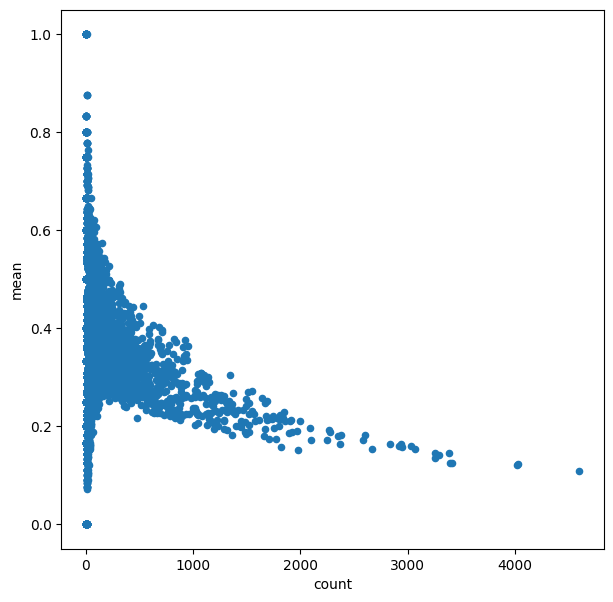

In [28]:
# aggregate to provider level
agg_df = code_df[['provider', 'clmDiagnosisCode', 'potentialFraudInd']] \
    .dropna().drop_duplicates()\
    .groupby('clmDiagnosisCode').agg({'potentialFraudInd':['mean', 'count', 'sum']})

agg_df.columns = [col[1] for col in agg_df.columns]

agg_df = agg_df.reset_index()

agg_df

agg_df.plot.scatter(x='count', y='mean')

__High number of claims__

Text(0.5, 0.98, 'Claim Count by Fraud Indicator')

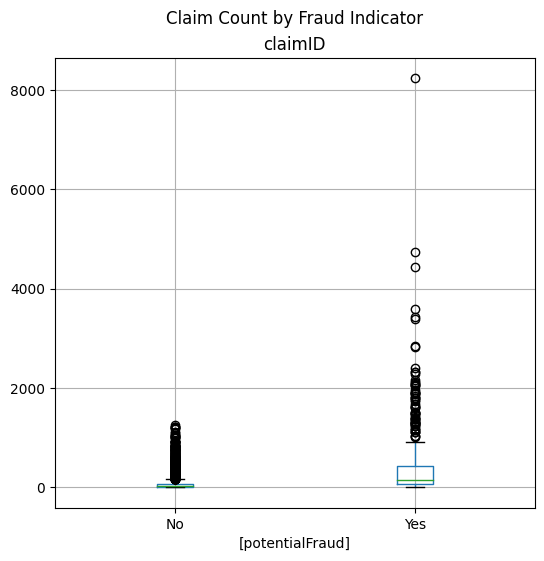

In [29]:
plt.rcParams["figure.figsize"] = (6,6)
agg_df = df[['provider','potentialFraud', 'claimID']].groupby(['provider', 'potentialFraud']).count().reset_index('potentialFraud')
ax = agg_df.boxplot(by='potentialFraud')
ax.get_figure().suptitle('Claim Count by Fraud Indicator')

Text(0.5, 0.98, 'Log Claim Count by Fraud Indicator')

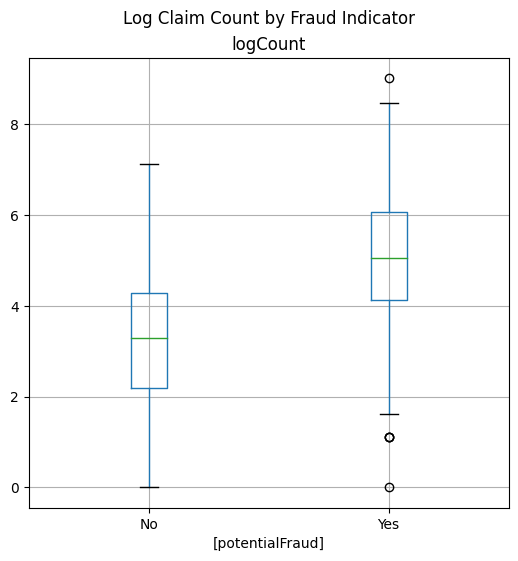

In [30]:
#lets use logs to make it easier to see
agg_df['logCount'] = np.log(agg_df['claimID'])
ax = agg_df[['potentialFraud', 'logCount']].boxplot(by='potentialFraud')
ax.get_figure().suptitle('Log Claim Count by Fraud Indicator')

This seems like a significant difference.  claim count should be included as a feature

In [31]:
feature_dfs['claimCount'] = agg_df.reset_index().drop(columns=['potentialFraud', 'logCount']).rename(columns={'claimID':'claimCount'})
feature_dfs['claimCount']

,provider,claimCount
0,PRV51001,25
1,PRV51003,132
2,PRV51004,149
3,PRV51005,1165
4,PRV51007,72
...,...,...
5405,PRV57759,28
5406,PRV57760,22
5407,PRV57761,82
5408,PRV57762,1


__High claim reimbursments amounts__

Text(0.5, 0.98, 'Claim Log Average Insurance Reimbursment by Fraud Indicator')

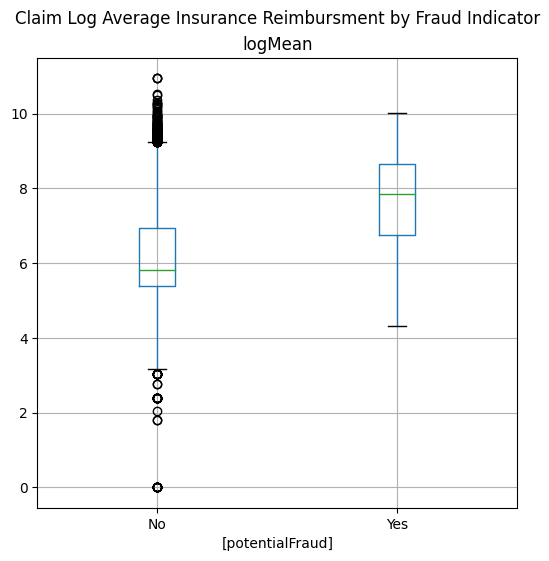

In [32]:
agg_df = df[['provider','potentialFraud', 'inscClaimAmtReimbursed']].groupby(['provider', 'potentialFraud']).mean().reset_index('potentialFraud')
agg_df['logMean'] = np.log(agg_df['inscClaimAmtReimbursed'] + 1)
ax = agg_df[['potentialFraud', 'logMean']].boxplot(by='potentialFraud')
ax.get_figure().suptitle('Claim Log Average Insurance Reimbursment by Fraud Indicator')

This also looks significant.  We should include mean reimbursement as a fearture

In [33]:
feature_dfs['avgClaimAmtReimbursed'] = agg_df.reset_index().drop(columns=['potentialFraud', 'logMean'])\
    .rename(columns={'inscClaimAmtReimbursed':'avgClaimAmtReimbursed'})
feature_dfs['avgClaimAmtReimbursed']

,provider,avgClaimAmtReimbursed
0,PRV51001,4185.600000
1,PRV51003,4588.409091
2,PRV51004,350.134228
3,PRV51005,241.124464
4,PRV51007,468.194444
...,...,...
5405,PRV57759,380.000000
5406,PRV57760,216.818182
5407,PRV57761,225.243902
5408,PRV57762,1900.000000


__Lack of physician presence on the claim__

In [34]:
# Reshape dfs to long on physicians
df = df.rename(columns = {'oprPhysicianInd': 'physicianIndOpr', 'attPhysicianInd': 'physicianIndAtt', 'otherPhysicianInd': 'physicianIndOther'})
phys_cols = [col for col in df.columns if 'physicianInd' in col]
phys_df = pd.wide_to_long(df[phys_cols  + ['claimID', 'provider', 'potentialFraudInd']], stubnames='physicianInd', i='claimID', j='physicianType', suffix='\D+').dropna().reset_index()
phys_df

,claimID,physicianType,potentialFraudInd,provider,physicianInd
0,CLM46614,Opr,1,PRV55912,0
1,CLM565430,Opr,1,PRV55912,1
2,CLM34721,Opr,1,PRV55912,1
3,CLM72336,Opr,1,PRV55912,1
4,CLM73394,Opr,1,PRV55912,1
...,...,...,...,...,...
1674628,CLM394122,Other,0,PRV54050,1
1674629,CLM184358,Other,0,PRV54302,0
1674630,CLM460770,Other,0,PRV51577,0
1674631,CLM306999,Other,0,PRV53083,0


Text(0.5, 0.98, 'Claim Fraction Physician Presence by Fraud Indicator')

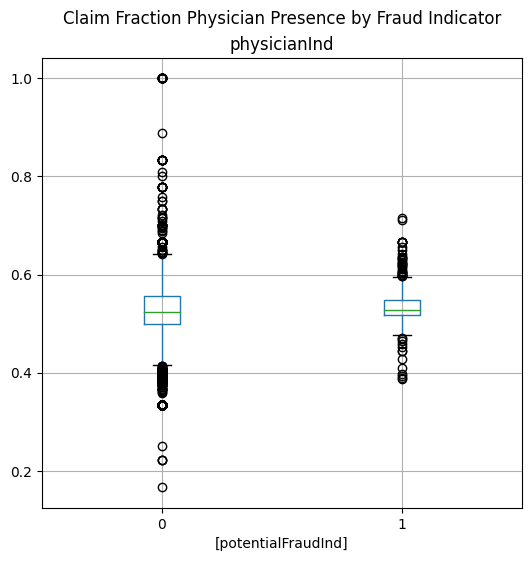

In [35]:
# aggregate to provider level and box plot
agg_df = phys_df[['provider', 'physicianInd', 'potentialFraudInd']] \
    .groupby(['provider', 'potentialFraudInd']).mean().reset_index('potentialFraudInd')

ax = agg_df.boxplot(by='potentialFraudInd')
ax.get_figure().suptitle('Claim Fraction Physician Presence by Fraud Indicator')

This doesn't look to vary much between fraud and non-fraud providers.  Lets not use this as a feature for now

__Inconsistent patient demographics (i.e. high varience in age)__

Inconsitent patient conditions (i.e. high variance in chronic conditions and desease)

In [36]:
provider_feat_df = provider_df.drop(columns='potentialFraud')
for feature_df in feature_dfs.values():
    provider_feat_df = provider_feat_df.merge(feature_df, on='provider')
provider_feat_df

,provider,potentialFraudInd,inpationFraction,renalDiseaseIndicatorNumEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,...,chronicCondCancerIndEnc,chronicCondObstrPulmonaryIndEnc,chronicCondDepressionIndEnc,chronicCondDiabetesIndEnc,chronicCondIschemicHeartIndEnc,chronicCondOsteoporasisIndEnc,chronicCondrheumatoidarthritisIndEnc,chronicCondstrokeIndEnc,claimCount,avgClaimAmtReimbursed
0,PRV51001,0,0.200000,0.027972,0.052448,0.066434,0.059441,0.017483,0.034965,0.031469,...,0.017483,0.034965,0.031469,0.073427,0.080420,0.020979,0.027972,0.020979,25,4185.600000
1,PRV51003,1,0.469697,0.023596,0.045566,0.065094,0.052075,0.008137,0.033360,0.043938,...,0.008137,0.033360,0.043938,0.081367,0.091131,0.026851,0.030919,0.009764,132,4588.409091
2,PRV51004,0,0.000000,0.017464,0.048595,0.066819,0.037965,0.012149,0.031131,0.047836,...,0.012149,0.031131,0.047836,0.079727,0.082005,0.037206,0.034928,0.012908,149,350.134228
3,PRV51005,1,0.000000,0.024998,0.041116,0.065631,0.048934,0.015925,0.028472,0.046810,...,0.015925,0.028472,0.046810,0.077116,0.086382,0.033201,0.031947,0.011968,1165,241.124464
4,PRV51007,0,0.041667,0.018003,0.042553,0.065466,0.036007,0.019640,0.026187,0.047463,...,0.019640,0.026187,0.047463,0.080196,0.083470,0.034370,0.036007,0.019640,72,468.194444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,0.000000,0.016722,0.046823,0.066890,0.050167,0.013378,0.036789,0.030100,...,0.013378,0.036789,0.030100,0.066890,0.093645,0.043478,0.030100,0.013378,28,380.000000
5406,PRV57760,0,0.000000,0.000000,0.019481,0.071429,0.012987,0.000000,0.012987,0.045455,...,0.000000,0.012987,0.045455,0.116883,0.142857,0.071429,0.006494,0.000000,22,216.818182
5407,PRV57761,0,0.000000,0.028152,0.044064,0.068543,0.048960,0.017136,0.036720,0.046512,...,0.017136,0.036720,0.046512,0.067319,0.075887,0.039168,0.029376,0.012240,82,225.243902
5408,PRV57762,0,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000,0.000000,...,0.100000,0.100000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000,1,1900.000000


Write to CSV and then to cloud storage

In [37]:
provider_feat_df.to_csv(DATA_DIR + 'baseline.csv', index=False)

In [40]:
from dotenv import load_dotenv
import os

load_dotenv('config.env', override=True)
REGION = os.getenv('GCLOUD_REGION')
shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]

STORAGE_BUCKET = PROJECT_ID + '-fsi'
os.environ["GCLOUD_PROJECT"] = PROJECT_ID

In [41]:
from google.cloud import storage

client = storage.Client()
bucket = client.bucket(STORAGE_BUCKET)
if not bucket.exists():
    bucket.create(location=REGION)

In [43]:
blob = bucket.blob(os.path.join('insurance_fraud', 'baseline.csv'))
blob.upload_from_filename(DATA_DIR + 'baseline.csv')